In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
emotion_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
df=pd.read_csv('/kaggle/input/facial-expression/fer2013.csv')

In [8]:
df.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [9]:
m,n = df.shape
print(m,n)

35887 3


In [10]:
training_index = 0
validate_index = 0
test_index = 0
for i in range(len(df)):
    if df.iloc[i]['Usage'] == 'Training':
        training_index = max(training_index,i)
    elif df.iloc[i]['Usage'] == 'PublicTest':
        validate_index = max(validate_index,i)
    elif df.iloc[i]['Usage'] == 'PrivateTest':
        test_index = max(test_index,i)
print(training_index,validate_index,test_index)

28708 32297 35886


In [11]:
def preprocess_data(data):
    labels = data['emotion'].values
    
    # Takes string values and forms an array with float32 data points of size 48 by 48
    images = data['pixels'].apply(lambda x: np.array(x.split(), dtype='float32').reshape(48, 48))
    
    # Stack images into a 3D array (num_samples, 48, 48) -> (35887, 48, 48)
    images = np.stack(images.values)  
    
    # Add a channel dimension for grayscale -> (num_samples, channels, 48, 48) -> (35887, 1, 48, 48)
    # Pytorch models expect in format of (batch_size, channels, height, width)
    images = np.expand_dims(images, axis=1)  
    
    # Normalize pixel values to [0, 1]
    images /= 255.0  
    return images, labels

# Split data into train and test datasets
train_images, train_labels = preprocess_data(df[:training_index])
validate_images, validate_labels = preprocess_data(df[training_index:validate_index])
test_images, test_labels = preprocess_data(df[validate_index:])


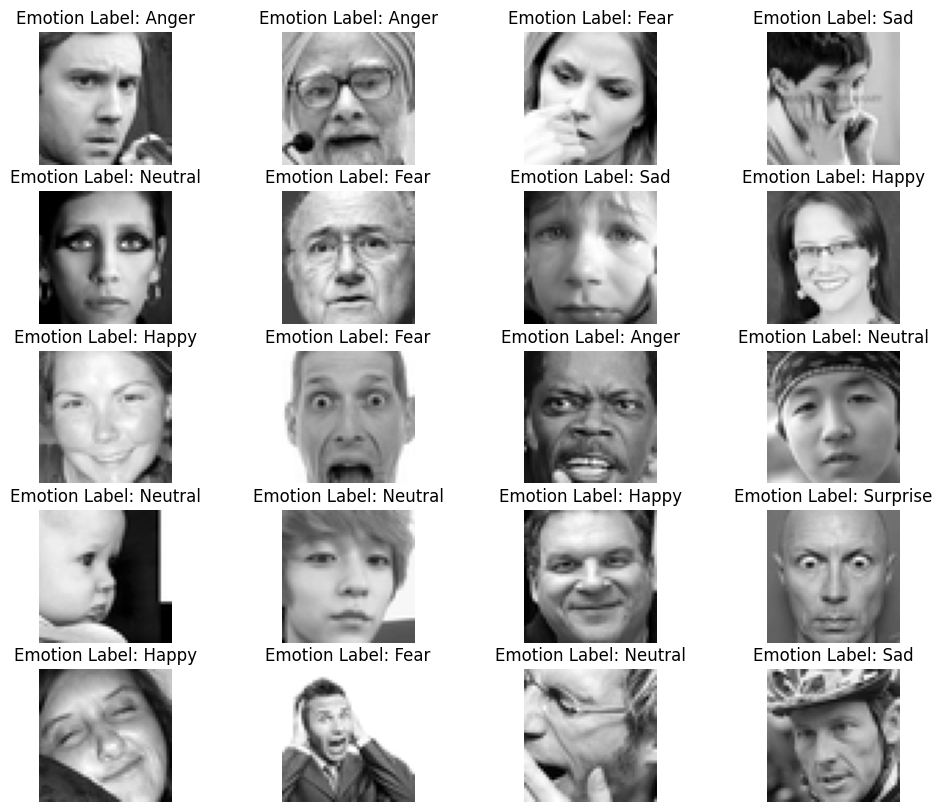

In [12]:
num_images = 20
num_cols = 4

# Calculate the number of rows needed
num_rows = (num_images + num_cols - 1) // num_cols  # Ceiling division

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 2))
axes = axes.flatten()

for i in range(num_images):
    ex_emotion = emotion_map[train_labels[i]]  # Provides format of (1,48,48)
    ex_image = train_images[i].squeeze()  # Squeezes first dimension to become (48,48)

    # Displaying with pyplot from matplotlib (do not need to convert back into 0-255, can keep as 0-1)
    axes[i].imshow(ex_image, cmap='gray')
    axes[i].set_title(f'Emotion Label: {ex_emotion}')
    axes[i].axis('off')

for j in range(num_images, len(axes)):
    axes[j].axis('off')

plt.show()

In [15]:
train_transforms = transforms.Compose([
#     transforms.RandomVerticalFlip(),
#     transforms.RandomHorizontalFlip(),
#     transforms.GaussianBlur(kernel_size=3),
#     transforms.RandomRotation(10),
#     transforms.RandomErasing(p=0.4),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

In [16]:

class FER2013Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.transform = transform
        print("Original shape of images",images.shape)
        print("Original shape of labels",labels.shape)
        pil = True
        transformed_images = []
        for i in range(len(images)):
            # scales image from 0-1 to 0-255
            scaled_image = (images[i] * 255).astype(np.uint8)
            
            # squeeze dimension from (1 - channel,48 - height,48 - width) to (48,48) bc grayscale
            scaled_image = scaled_image.squeeze(0)
            
            # converts the image into PIL format
            pil_image = Image.fromarray(scaled_image)
            
            if self.transform:
                # transforms image using transform function which unscales it and makes it a tensor
                transformed_image = transform(pil_image)
                if pil:
                    print(transformed_image)
                
                pil = False
                # append to list of transformed_images
                transformed_images.append(transformed_image)
        # stacks the array to make (25000 - len(transformed_images),1 - channel,48 - height,48 - width)
        self.images = torch.stack(transformed_images).float()
        self.labels = torch.tensor(labels, dtype=torch.long) 
        
        print("Final shape of images",self.images.shape)
        print("Final shape of labels",self.labels.shape)
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        return image, label

batch_size = 32
shuffle = True

# Create dataset instance
train_dataset = FER2013Dataset(train_images, train_labels, transform=train_transforms)
validate_dataset = FER2013Dataset(validate_images, validate_labels, transform=test_transforms)
test_dataset = FER2013Dataset(test_images, test_labels, transform=test_transforms)

# Create data loader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
validate_dataloader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Usually no need to shuffle test data

Original shape of images (28708, 1, 48, 48)
Original shape of labels (28708,)
tensor([[[0.2745, 0.3137, 0.3216,  ..., 0.2039, 0.1686, 0.1608],
         [0.2549, 0.2392, 0.2275,  ..., 0.2196, 0.2039, 0.1725],
         [0.1961, 0.1686, 0.2118,  ..., 0.1922, 0.2196, 0.1843],
         ...,
         [0.3569, 0.2549, 0.1647,  ..., 0.2824, 0.2196, 0.1686],
         [0.3020, 0.3216, 0.3098,  ..., 0.4118, 0.2745, 0.1804],
         [0.3020, 0.2824, 0.3294,  ..., 0.4157, 0.4275, 0.3216]]])
Final shape of images torch.Size([28708, 1, 48, 48])
Final shape of labels torch.Size([28708])
Original shape of images (3589, 1, 48, 48)
Original shape of labels (3589,)
tensor([[[0.7647, 0.7804, 0.8039,  ..., 0.7137, 0.5490, 0.3020],
         [0.7569, 0.7686, 0.7922,  ..., 0.7725, 0.6471, 0.4118],
         [0.7765, 0.7843, 0.8000,  ..., 0.8157, 0.7686, 0.6157],
         ...,
         [0.2235, 0.2863, 0.3294,  ..., 0.0118, 0.0784, 0.1294],
         [0.2392, 0.2863, 0.3765,  ..., 0.0235, 0.0745, 0.1608],
      

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((2, 2))
        
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 7)
        
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = self.adaptive_pool(x)
        x = x.view(-1, 256 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Model instantiation
model = DeepCNN().to(device)

In [21]:
num_epochs = 20
learning_rate = 0.001
patience = 4  # Number of epochs to wait for improvement in validation loss
best_val_loss = float('inf')  
patience_counter = 0  # Counter to track epochs with no improvement
early_stop = False 

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=4e-4)

# Best model weights initialization
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    if early_stop:
        print("Early stopping triggered!")
        break
    
    model.train()  # Set model to training mode
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{len(train_dataloader)}], Loss: {running_loss / (i + 1):.4f}')
    
    # Calculate and print the average training loss
    avg_train_loss = running_loss / len(train_dataloader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}')
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in validate_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Calculate average validation loss
    avg_val_loss = val_loss / len(validate_dataloader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())  # Save the best model weights
        patience_counter = 0  # Reset the patience counter
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter} out of {patience}")

        if patience_counter >= patience:
            print("Early stopping!")
            early_stop = True

model.load_state_dict(best_model_wts)

Epoch [1/20], Batch [100/898], Loss: 1.8418
Epoch [1/20], Batch [200/898], Loss: 1.8018
Epoch [1/20], Batch [300/898], Loss: 1.7620
Epoch [1/20], Batch [400/898], Loss: 1.7219
Epoch [1/20], Batch [500/898], Loss: 1.6970
Epoch [1/20], Batch [600/898], Loss: 1.6785
Epoch [1/20], Batch [700/898], Loss: 1.6633
Epoch [1/20], Batch [800/898], Loss: 1.6481
Epoch [1/20], Training Loss: 1.6345
Epoch [1/20], Validation Loss: 1.5114
Epoch [2/20], Batch [100/898], Loss: 1.5078
Epoch [2/20], Batch [200/898], Loss: 1.5091
Epoch [2/20], Batch [300/898], Loss: 1.4969
Epoch [2/20], Batch [400/898], Loss: 1.4944
Epoch [2/20], Batch [500/898], Loss: 1.4906
Epoch [2/20], Batch [600/898], Loss: 1.4902
Epoch [2/20], Batch [700/898], Loss: 1.4862
Epoch [2/20], Batch [800/898], Loss: 1.4785
Epoch [2/20], Training Loss: 1.4718
Epoch [2/20], Validation Loss: 1.4228
Epoch [3/20], Batch [100/898], Loss: 1.3932
Epoch [3/20], Batch [200/898], Loss: 1.4058
Epoch [3/20], Batch [300/898], Loss: 1.4064
Epoch [3/20], Ba

<All keys matched successfully>

In [22]:
from sklearn.metrics import classification_report, accuracy_score

model.eval()  # Set the model to evaluation mode
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy on test_data: {accuracy:.4f}')
print(classification_report(all_labels, all_preds))

Accuracy on test_data: 0.5827
              precision    recall  f1-score   support

           0       0.45      0.56      0.50       491
           1       0.00      0.00      0.00        55
           2       0.42      0.21      0.28       528
           3       0.76      0.85      0.80       879
           4       0.42      0.51      0.46       595
           5       0.75      0.72      0.73       416
           6       0.58      0.56      0.57       626

    accuracy                           0.58      3590
   macro avg       0.48      0.49      0.48      3590
weighted avg       0.57      0.58      0.57      3590



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
if False:
    torch.save(model.state_dict(), 'fer2013_n_model.pth')